In [3]:
import sympy as sp
import control
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use(plt.style.available[9])

In [4]:
H_num = [40]
H_den = [0.02,1.0,0]

H_s = control.tf(H_num,H_den)
H_s

TransferFunction(array([40]), array([0.02, 1.  , 0.  ]))

In [5]:
dt =0.01

H_z = control.c2d(H_s, dt, method='foh')

Hd_ss= control.tf2ss(H_z)
H_z

TransferFunction(array([0.02955094, 0.10481651, 0.02302028]), array([ 1.        , -1.60653066,  0.60653066]), 0.01)

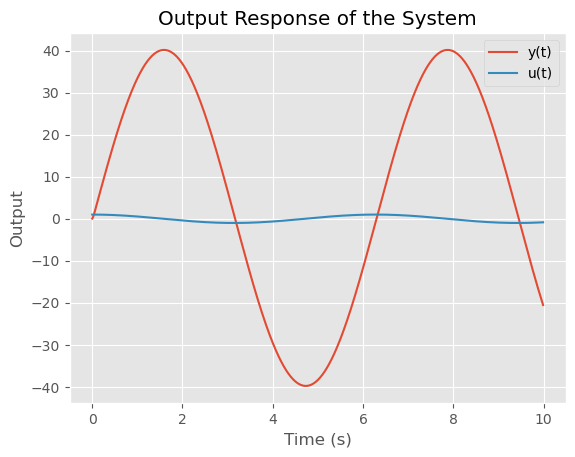

In [6]:
time = np.arange(0, 10, dt)
f = 1
u_data = np.cos(f*time)#+np.cos(2*time)+np.cos(3*time)

# Step 3: Simulate the output using forced_response
results = control.forced_response(Hd_ss, T=time, U=u_data)

# Plotting the results
plt.figure()
plt.plot(results.time, results.outputs,label='y(t)')
plt.plot(time,u_data,label='u(t)')
plt.title('Output Response of the System')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()

plt.show()

In [7]:
results.states.shape

(2, 1000)

## Discretize using Euler method:
$$
A_d = I+TA\\
B_d = TB\\
C_d =C\\
D_d = D\\
$$

In [8]:
class Identifier_Filter(nn.Module):
    def __init__(self,x0,A,B,C,D,T_sampling:float):
        super().__init__()
        self.x = x0
        self.Ad = torch.eye(A.shape[0])+T_sampling*torch.tensor(A).float()
        self.Bd = T_sampling*torch.tensor(B).float()
        self.Cd = torch.tensor(C).float()
        self.Dd = torch.tensor(D).float()
        
        
    def forward(self,u:torch.Tensor):
        x_k_plus1 = self.Ad@ self.x + self.Bd@u
        self.x = x_k_plus1.detach()
        xHat = self.Cd@self.x + self.Dd@u
        return xHat


## Create the NN identifier:


In [9]:
class Identifier(nn.Module):
    def __init__(self, SystemInputSize, systemStateNum,Filter:Identifier_Filter):
        super(Identifier, self).__init__()
        
        # Define the layers of the neural network
        self.Iden_Model = nn.Sequential(nn.Linear(SystemInputSize+systemStateNum ,8),
                           nn.Sigmoid(),
                           nn.Linear(8,8),
                           nn.Sigmoid(),
                           nn.Linear(8,systemStateNum))
        # self.Filter= Filter
        self.Filter = Filter

    def forward(self, x):
        xHat =  self.Iden_Model(x)
        
        return self.Filter(xHat.t()) 

In [10]:
def GetTheFilter_StateSpaceMats(A:sp.MutableDenseMatrix):
    s = sp.symbols('s')

    I = sp.eye(A.cols)
    
    M_s = (s*I-A).inv()
    sp.pprint(M_s)


    nums=[]
    dens=[]

    for entry in M_s:
        num_expr = sp.numer(entry)
        den_expr = sp.denom(entry)
        num_poly = sp.Poly(num_expr, s)
        den_poly = sp.Poly(den_expr, s)
        num_coeffs = [float(coef) for coef in num_poly.coeffs()]
        den_coeffs = [float(coef) for coef in den_poly.coeffs()]
        nums.append(num_coeffs)
        dens.append(den_coeffs)
    def GetNumDenReady(size,input):

        output = [[] for i in range(size)]


        for index, item in enumerate(input):
            group_index = index % size
            output[group_index].append(item)
        return output

    nums = GetNumDenReady(M_s.cols,nums)
    dens = GetNumDenReady(M_s.cols,dens)
    M_system = control.tf(nums, dens)
    ss_sys=control.tf2ss(M_system) 
    A = ss_sys.A
    B = ss_sys.B
    C = ss_sys.C
    D = ss_sys.D
    return (A,B,C,D)



In [11]:
SystemInputSize = 1 # the system is SISO
systemStateNum  = results.states.shape[0]
A_filter=-0.01*sp.eye(systemStateNum)

(A,B,C,D)=GetTheFilter_StateSpaceMats(A_filter)
x0 = torch.zeros(systemStateNum,1)
Id_filter = Identifier_Filter(x0,A,B,C,D,T_sampling=dt)


Identifier = Identifier(SystemInputSize,systemStateNum,Filter=Id_filter)



⎡   1              ⎤
⎢────────     0    ⎥
⎢s + 0.01          ⎥
⎢                  ⎥
⎢             1    ⎥
⎢   0      ────────⎥
⎣          s + 0.01⎦


In [19]:
LearningRate =0.0001
LossFun = nn.MSELoss()
optimizer = torch.optim.SGD(Identifier.parameters(),lr=LearningRate)



Error_history=[]
Error_history_mean=[]
xHat = results.states[:,0].reshape(-1,1)
EpochNum = 10
for epochi in range(EpochNum):
    error=[]
    for i in range(len(time)):
        x = results.states[:,i].reshape(-1,1)
        u = u_data[i].reshape(-1,1)

        input = np.concatenate((u,xHat))
        NN_input = torch.tensor(input).float()

        xHat = Identifier(NN_input.t())

        x = torch.tensor(x).float()
        
        loss = LossFun(x,xHat)

        ## Get xHat ready for next iteration:
        xHat = xHat.detach().numpy()

        error.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    Error_history.append(error)
    Error_history_mean.append(np.mean(error))



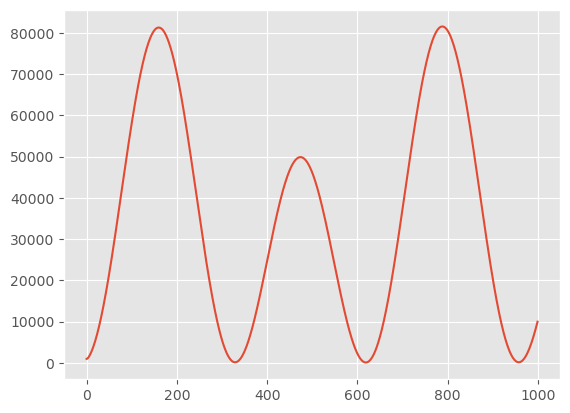

In [20]:
plt.plot(Error_history[-1])
plt.show()

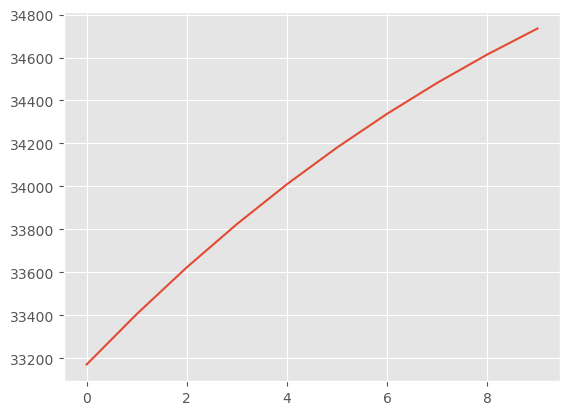

In [21]:
plt.plot(Error_history_mean)
plt.show()